## AUC in Catboost

The tutorial is dedicated to The area under the receiver operating characteristic (ROC) curve (AUC) metric implemented in CatBoost for binary classification, multiclass classification and ranking problems.

### About AUC
Building and visualizing the ROC curve could be used to measure classification algorithm performance with different probability boundary and select the probability boundary required to achieve the specified false positive or false negative rate.

The AUC has an important statistical property: the AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

### Useful links
Read more about ROC on [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

To get understanding of ROC curve building from scratch see [the article](https://people.inf.elte.hu/kiss/11dwhdm/roc.pdf).

To get understanding of AUC$\mu$ for multiclass classification see [the article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf).  

### Library installation

In [2]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install --upgrade sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 64.0MB 56kB/s 
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.1)
     |████████████████████████████████| 276kB 4.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394166 sha256=b8dd88b2bccf0ce43cfd620d3fb020fac0592b028ad4fceb5c99d22ef9935749
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)
     |████████████████████████████████| 20.2MB 64.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
import catboost
print(catboost.__version__)
!python --version

0.21
Python 3.6.9


In [0]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
import sklearn
import matplotlib.pyplot as plt

from catboost import datasets, Pool
from catboost.utils import get_roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split

### AUC for binary classification

#### Loading dataset

We will use the  [UCI Adult Data Set](https://catboost.ai/docs/concepts/python-reference_datasets_uci-adult.html) for binary classification problem

In [0]:
(train_df, test_df) = datasets.adult()

In [69]:
train_df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,0


We will just drop NA for simplicity.

In [0]:
train_df.dropna(inplace=True)

#### Creating pool

In [71]:
y = train_df['income']
X = train_df.drop(columns='income')
y.unique()

array([0, 1])

In [72]:
y.loc[y == '<=50K'] = 0
y.loc[y == '>50K'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [0]:
train_pool = Pool(X_train, y_train, cat_features)
validation_pool = Pool(X_validation, y_validation, cat_features)

#### Training model

In [76]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
    eval_metric='AUC',
    loss_function='CrossEntropy',
    train_dir='model_dir',
    random_seed=42)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=True, 
);

0:	test: 0.8710436	best: 0.8710436 (0)	total: 22.6ms	remaining: 3.37s
1:	test: 0.8833383	best: 0.8833383 (1)	total: 39.4ms	remaining: 2.92s
2:	test: 0.8868709	best: 0.8868709 (2)	total: 58.8ms	remaining: 2.88s
3:	test: 0.8918383	best: 0.8918383 (3)	total: 77.3ms	remaining: 2.82s
4:	test: 0.8911026	best: 0.8918383 (3)	total: 96.5ms	remaining: 2.8s
5:	test: 0.8934638	best: 0.8934638 (5)	total: 114ms	remaining: 2.73s
6:	test: 0.8926112	best: 0.8934638 (5)	total: 132ms	remaining: 2.69s
7:	test: 0.8937238	best: 0.8937238 (7)	total: 149ms	remaining: 2.64s
8:	test: 0.8950280	best: 0.8950280 (8)	total: 169ms	remaining: 2.65s
9:	test: 0.8957628	best: 0.8957628 (9)	total: 192ms	remaining: 2.69s
10:	test: 0.8960068	best: 0.8960068 (10)	total: 210ms	remaining: 2.65s
11:	test: 0.8964731	best: 0.8964731 (11)	total: 231ms	remaining: 2.65s
12:	test: 0.8965941	best: 0.8965941 (12)	total: 248ms	remaining: 2.61s
13:	test: 0.8969076	best: 0.8969076 (13)	total: 266ms	remaining: 2.59s
14:	test: 0.8972569	be

In [77]:
model.get_best_score()

{'learn': {'CrossEntropy': 0.31156899653329495},
 'validation': {'AUC': 0.9151075753419289,
  'CrossEntropy': 0.31345370943562295}}

AUC on validation set is 0.915

In [85]:
roc_auc = model.eval_metrics(validation_pool, 'AUC')['AUC'][-1]
print('AUC on validation dataset is equal to {0:.4f}'.format(roc_auc)) 

AUC on validation dataset is equal to 0.9151


#### Visualizing ROC curve

In [0]:
curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve
# roc_auc = sklearn.metrics.auc(fpr, tpr)

# print('ROC AUC on validation dataset is equal to {0:.4f}'.format(roc_auc))

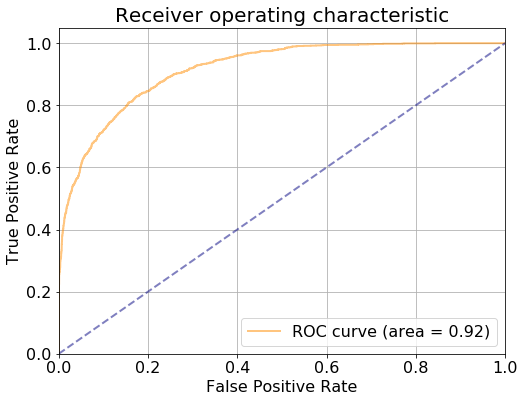

In [87]:
plt.figure(figsize=(8, 6))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Visualizing FPR and FTR

In [0]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

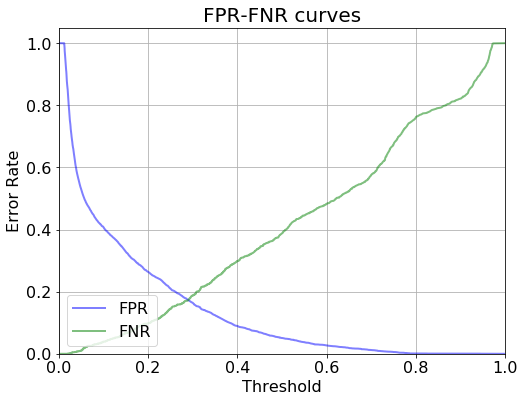

In [89]:
plt.figure(figsize=(8, 6))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

#### Selecting decision boundary (probability threshold)

In [0]:
from catboost.utils import select_threshold

Let's assume we want don't want to have many false positives and be sure we do not asign the class 1 (income >50K) to persons with income <=50K in 90% cases, which means FPR = 0.1

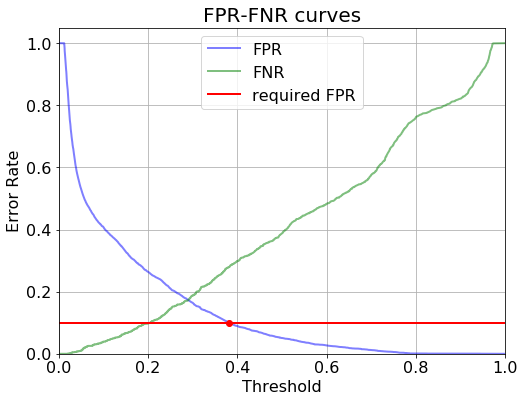

In [91]:
plt.figure(figsize=(8, 6))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
plt.axhline(0.1, lw=lw, color='red', label='required FPR')
plt.plot(0.382, 0.1, color='red', marker='o', lw=5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [92]:
threshold = select_threshold(model=model, data=validation_pool, FPR=0.1)
print('Threshold for FPR = 0.1 is {0:.4f}'.format(select_threshold(model=model, data=validation_pool, FPR=0.1)))
# print('Threshold for FNR = 0.1 is {0:.4f}'.format(select_threshold(model=model, data=validation_pool, FNR=0.1)))

Threshold for FPR = 0.1 is 0.3828


To apply threshold use .predict_proba()

In [0]:
res = model.predict_proba(validation_pool)
predictions = np.zeros((res.shape[0]), dtype=int)
predictions[res[:, 1] > threshold] = 1

In [0]:
from sklearn.metrics import confusion_matrix

In [95]:
tn, fp, fn, tp = confusion_matrix(y_validation, predictions).ravel()
count = np.sum([tn, fp, fn, tp])
print('tnr={0:.4f}, fpr={1:.4f}, fnr={2:.4f}, tpr={3:.4f}'. format(tn/(tn+fp), fp/(fp+tn), fn/(fn+tp), tp/(tp+fn)))

tnr=0.9001, fpr=0.0999, fnr=0.2804, tpr=0.7196


FPR is as required

### AUC for multiclass classification

There are two AUC metrics inplemented for multiclass classification in Catboost. 

The first is **OneVsAll**, AUC value is calculated separately for each class according to the binary classification calculation principles. 

The second in **AUC$\mu$** is designed to meet the following properties:

* Property 1. If a model gives the correct label the highest probability 
on every example, then AUC = 1
* Property 2. Random guessing on examples yields AUC = 0.5
* Property 3. AUC is insensitive to class skew

AUC$\mu$ could be interpreted as an average of pairwise AUCs between the classes. Details could be found in the [article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf). 


#### Loading dataset

We will use the [Wine recognition dataset](https://scikit-learn.org/stable/datasets/index.html#wine-dataset ) for multiclass classification problem

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2020-02-29 15:18:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0s      

2020-02-29 15:18:23 (111 MB/s) - ‘wine.data’ saved [10782/10782]



In [0]:
columns = ['Class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', 'OD280OD315_of_diluted_wines', 'Proline']
train_df = pd.read_csv('wine.data', names=columns)

In [5]:
train_df.head(5)

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Creating pool

In [12]:
y = train_df['Class']
X = train_df.drop(columns='Class')
y.unique()

array([1, 2, 3])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.6, random_state=42)

In [0]:
train_pool = Pool(X_train, y_train)
validation_pool = Pool(X_validation, y_validation)

#### Training model

AUC$\mu$ could be used as evaluation metric to prevent overfitting, while OneVsAll AUC could be used only for information as contains k values (k is the number of classes). 

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    eval_metric='AUC',
    custom_metric=['AUC:type=OneVsAll;hints=skip_train~false',],
    # metric_period=10,
    loss_function='MultiClass',
    train_dir='model_dir',
    random_seed=42)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=True, 
);

0:	test: 0.9746589	best: 0.9746589 (0)	total: 49.6ms	remaining: 2.43s
1:	test: 0.9836807	best: 0.9836807 (1)	total: 53.5ms	remaining: 1.28s
2:	test: 0.9928525	best: 0.9928525 (2)	total: 57.1ms	remaining: 894ms
3:	test: 0.9909032	best: 0.9928525 (2)	total: 61.9ms	remaining: 712ms
4:	test: 0.9961014	best: 0.9961014 (4)	total: 67.2ms	remaining: 604ms
5:	test: 0.9980507	best: 0.9980507 (5)	total: 72.1ms	remaining: 528ms
6:	test: 0.9987005	best: 0.9987005 (6)	total: 77.1ms	remaining: 474ms
7:	test: 1.0000000	best: 1.0000000 (7)	total: 83ms	remaining: 436ms
8:	test: 1.0000000	best: 1.0000000 (7)	total: 86ms	remaining: 392ms
9:	test: 1.0000000	best: 1.0000000 (7)	total: 88.7ms	remaining: 355ms
10:	test: 1.0000000	best: 1.0000000 (7)	total: 91.4ms	remaining: 324ms
11:	test: 1.0000000	best: 1.0000000 (7)	total: 94.1ms	remaining: 298ms
12:	test: 1.0000000	best: 1.0000000 (7)	total: 96.8ms	remaining: 276ms
13:	test: 1.0000000	best: 1.0000000 (7)	total: 99.5ms	remaining: 256ms
14:	test: 1.0000000	

In [16]:
model.get_best_score()

{'learn': {'AUC:class=0': 1.0,
  'AUC:class=1': 1.0,
  'AUC:class=2': 1.0,
  'MultiClass': 0.4492892398267346},
 'validation': {'AUC:class=0': 1.0,
  'AUC:class=1': 1.0,
  'AUC:class=2': 1.0,
  'AUC:type=Mu': 1.0,
  'MultiClass': 0.5113925599493855}}

In [0]:
AUCs = model.eval_metrics(validation_pool, metrics=['AUC:type=Mu', 'AUC:type=OneVsAll'])

In [18]:
print('AUC:type=OneVsAll:')
print('AUC:class=0 = {0:.4f}, AUC:class=1 = {1:.4f}, AUC:class=2 = {2:.4f}'.format(AUCs['AUC:class=0'][-1], AUCs['AUC:class=1'][-1], AUCs['AUC:class=2'][-1]))

print('\nAUC:type=Mu:')
print('AUC:type=Mu = {0:.4f}'.format(AUCs['AUC:type=Mu'][-1]))

AUC:type=OneVsAll:
AUC:class=0 = 1.0000, AUC:class=1 = 1.0000, AUC:class=2 = 0.9980

AUC:type=Mu:
AUC:type=Mu = 1.0000


Я так поняла, что усредненный Catboost OneVsAll AUC соответствует sklearn ovr AUC, а Catboost AUC$\mu$ соответствует sklearn ovo AUC. Но полученные значения не совпадают :(

In [19]:
sklearn_ovo_auc = sklearn.metrics.roc_auc_score(y_validation, model.predict_proba(validation_pool), multi_class='ovo')
sklearn_ovr_auc = sklearn.metrics.roc_auc_score(y_validation, model.predict_proba(validation_pool), multi_class='ovr')
print('sklearn ovo AUC = {0:.4f}'.format(sklearn_ovo_auc))
print('sklearn ovr AUC = {0:.4f}'.format(sklearn_ovr_auc))

sklearn ovo AUC = 0.9994
sklearn ovr AUC = 0.9993


In [0]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(y_validation, model.predict(validation_pool))

array([[26,  0,  0],
       [ 0, 27,  0],
       [ 1,  0, 18]])

Видно, что AUC не единица, т.е. скорее sklearn правильно считает AUC.  

#### Visualizing ROC curve

In [16]:
curve = get_roc_curve(model, validation_pool)
# (fpr, tpr, thresholds) = curve
# roc_auc = sklearn.metrics.auc(fpr, tpr)

# print('ROC AUC on validation dataset is equal to {0:.4f}'.format(roc_auc))

CatBoostError: ignored

get_roc_curve работает только для бинарной классификации? 

что нужно добавить в часть туториала по мультиклассификации? Нужно ли вручную строить кривые для ОneVsother? или считать на простых примерах AUC для AUC$\mu$?

### AUC for ranking

We will use the [msrank_10k dataset](https://catboost.ai/docs/concepts/python-reference_datasets_msrank_10k.html), smaller version of the Microsoft Learning to Rank Dataset for ranking problem

In [0]:
(train_df, test_df) = datasets.msrank_10k()

In [56]:
train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,0.0,1.0,156,4,0,7,167,6.931275,22.076928,19.673353,22.255383,6.926551,3,3,0,0,6,1,1,0,0,2,1,1,0,0,2,1.000000,1.0,0.000000,...,1,0,0,1,1.000000,1.0,0.000000,0.0,1.000000,12.941469,20.59276,0.000000,0.0,16.766961,-18.567793,-7.760072,-20.838749,-25.436074,-14.518523,-21.710022,-21.339609,-24.497864,-27.690319,-20.203779,-15.449379,-4.474452,-23.634899,-28.119826,-13.581932,3,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,1.0,406,0,5,5,416,6.931275,22.076928,19.673353,22.255383,6.926551,28,0,3,0,31,8,0,1,0,9,10,0,1,0,11,9.333333,0.0,1.000000,...,0,1,0,1,0.994425,0.0,1.000000,0.0,0.995455,20.885118,0.00000,24.233365,0.0,21.161666,-11.555850,-21.242171,-8.429024,-25.436074,-11.297811,-16.487275,-24.805464,-21.461317,-27.690319,-16.208808,-11.646141,-24.041386,-5.143860,-28.119826,-11.411068,2,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,0.0,1.0,146,0,3,7,156,6.931275,22.076928,19.673353,22.255383,6.926551,14,0,2,0,16,1,0,0,0,1,7,0,1,0,8,4.666667,0.0,0.666667,...,0,0,0,1,0.851903,0.0,0.720414,0.0,0.842789,18.140878,0.00000,17.748073,0.0,18.279205,-12.609065,-21.242171,-14.935056,-25.436074,-12.487989,-18.832941,-24.805464,-23.925663,-27.690319,-18.589543,-11.525277,-24.041386,-14.689844,-28.119826,-11.436378,3,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,1.0,287,1,4,7,299,6.931275,22.076928,19.673353,22.255383,6.926551,7,0,3,0,10,2,0,1,0,3,3,0,1,0,4,2.333333,0.0,1.000000,...,0,1,0,1,0.989585,0.0,1.000000,0.0,0.995185,15.572998,0.00000,26.759999,0.0,17.531630,-15.555640,-21.242171,-7.761830,-25.436074,-14.198901,-20.103511,-24.805464,-21.459820,-27.690319,-19.180736,-14.798285,-24.041386,-4.474536,-28.119826,-13.825417,3,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,1.0,2009,2,4,7,2022,6.931275,22.076928,19.673353,22.255383,6.926551,8,0,3,0,11,2,0,1,0,3,3,0,1,0,4,2.666667,0.0,1.000000,...,0,1,0,1,0.980551,0.0,1.000000,0.0,0.989938,7.802556,0.00000,26.759999,0.0,9.749707,-20.673887,-21.242171,-7.761830,-25.436074,-19.469471,-21.419394,-24.805464,-21.459820,-27.690319,-20.589940,-20.168345,-24.041386,-4.474536,-28.119826,-19.226044,3,64,5,7,256,49697,1,13,0,0,0.0


The first column is relevance with values {0, 1, 2, 3, 4}, the second column in query IDs, which we will use as groups.


In [0]:
# map relevance to [0, 1]
train_df.loc[:, 0] = train_df.loc[:, 0] / 4

In [0]:
# sort values of groups columns
train_df.sort_values(by=1, axis=0, inplace=True)
test_df.sort_values(by=1, axis=0, inplace=True)

In [0]:
X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

#### Creating pool

In [0]:
train_pool = Pool(X_train, y_train, group_id=queries_train)
test_pool = Pool(X_test, y_test, group_id=queries_train)

#### Training model

In [61]:
from catboost import CatBoost
params = {
    'iterations':50,
    'eval_metric':'AUC:type=Ranking',
    'loss_function':'YetiRankPairwise',
    'train_dir':'model_dir',
    'random_seed':42}

model = CatBoost(params)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=True, 
);

0:	test: 0.6692329	best: 0.6692329 (0)	total: 539ms	remaining: 26.4s
1:	test: 0.6753052	best: 0.6753052 (1)	total: 1.08s	remaining: 26s
2:	test: 0.6828906	best: 0.6828906 (2)	total: 1.64s	remaining: 25.7s
3:	test: 0.6823792	best: 0.6828906 (2)	total: 2.23s	remaining: 25.6s
4:	test: 0.6810798	best: 0.6828906 (2)	total: 2.78s	remaining: 25s
5:	test: 0.6814050	best: 0.6828906 (2)	total: 3.33s	remaining: 24.4s
6:	test: 0.6809098	best: 0.6828906 (2)	total: 3.87s	remaining: 23.8s
7:	test: 0.6796002	best: 0.6828906 (2)	total: 4.42s	remaining: 23.2s
8:	test: 0.6829305	best: 0.6829305 (8)	total: 4.97s	remaining: 22.6s
9:	test: 0.6860951	best: 0.6860951 (9)	total: 5.51s	remaining: 22.1s
10:	test: 0.6869308	best: 0.6869308 (10)	total: 6.06s	remaining: 21.5s
11:	test: 0.6858753	best: 0.6869308 (10)	total: 6.6s	remaining: 20.9s
12:	test: 0.6876734	best: 0.6876734 (12)	total: 7.16s	remaining: 20.4s
13:	test: 0.6880466	best: 0.6880466 (13)	total: 7.71s	remaining: 19.8s
14:	test: 0.6873415	best: 0.688

In [0]:
AUC = model.eval_metrics(test_pool, metrics=['AUC:type=Ranking'])

In [72]:
roc_auc = AUC['AUC:type=Ranking'][-1]
print('AUC:type=Ranking = {0:.4f}'.format(roc_auc))

AUC:type=Ranking = 0.6958


#### Visualizing ROC curve

In [0]:
curve = get_roc_curve(model, test_pool)
(fpr, tpr, thresholds) = curve

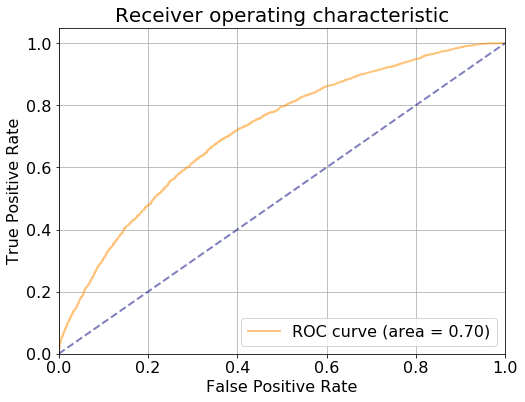

In [74]:
plt.figure(figsize=(8, 6))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()